In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
from cloudy_fit_lib import *
from scipy.interpolate import RegularGridInterpolator
import pickle
import corner
from scipy import integrate, interpolate
import emcee

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/CUBS/Code/science.mplstyle')

In [3]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/cloudy_grids/'

In [4]:
savedir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z=0.72882547/cloudy_fits/'

Obtain the UVB grid from FG20

In [5]:
fg20_z_grid, fg20_wav_grid, fg20_J_nu_grid = read_uvb('', 'fg20_galaxy.ascii')

Fetch the SED at $z=1$

In [6]:
z_test = 1

In [7]:
fg20_J_nu_test = fetch_sed(z_test, fg20_z_grid, fg20_J_nu_grid)

Specify $N_{\mathrm{HI}}$ grid points and get corresponding filenames

In [8]:
logN_HI_min = 12
logN_HI_max = 17
logN_HI_step = 0.25

logN_HI_arr = np.arange(logN_HI_min, logN_HI_max+logN_HI_step, logN_HI_step)

In [9]:
file_list = create_grid_file_list(logN_HI_arr)

Specify grid points for densities and metallicities

In [10]:
log_hdens_min = -5
log_hdens_max = 1
log_hdens_step = 0.25

log_hdens_arr = np.arange(log_hdens_min, log_hdens_max+log_hdens_step, log_hdens_step)
logU_arr = np.log10(calc_U(fg20_wav_grid, fg20_J_nu_test, 10**log_hdens_arr))

In [11]:
log_metals_min = -3
log_metals_max = 1
log_metals_step = 0.25

log_metals_arr = np.arange(log_metals_min, log_metals_max+log_metals_step, log_metals_step)

Load the final grid

In [12]:
pkl_file = open(rootdir+'final_grid.pkl', 'rb')
species_logN_samples = pickle.load(pkl_file)
pkl_file.close()

Interpolate this grid

In [13]:
species_logN_interp = {}

for s in list(species_logN_samples.keys()):
    
    species_logN_samples[s][species_logN_samples[s]==-np.inf] = -99
    
    species_logN_interp[s] = RegularGridInterpolator((logN_HI_arr, log_hdens_arr, log_metals_arr), 
                                                     species_logN_samples[s])

# First look

Enter measurements for species

In [14]:
logN_dict = {'HI':'16.67, -0.02, +0.02',
            'CII':'<12.6',
            'CIII':'13.42, -0.06, +0.09',
            'CIV':'<12.8',
            'NII':'<13.5',
            'NIII':'<12.8',
            'NIV':'<12.5',
            'OII':'<12.7',
            'OIII':'13.97, -0.03, +0.03',
            'OIV':'14.38, -0.02, +0.02',
            'OVI':'14.16, -0.07, +0.07',
            'NeVIII':'<13.6',
            'MgII':'<11.0',
            'AlIII':'<11.5',
            'SiII':'<12.2',
            'SiIII':'<12.3',
            'SiIV':'<12.2',
            'SIV':'<12.4',
            'SV':'<12.0',
            'SVI':'<13.0',
            'FeII':'<11.3',}

Try out a new solution including sub-solar [C/O]

In [15]:
logN_HI_test = 16.67
log_hdens_test =  -2.9
log_metals_test = -2.6

In [16]:
logN_species_test = predict_col_dens(logN_dict, logN_HI_test, log_hdens_test, log_metals_test, 
                                     species_logN_interp, {'C':-0.45})

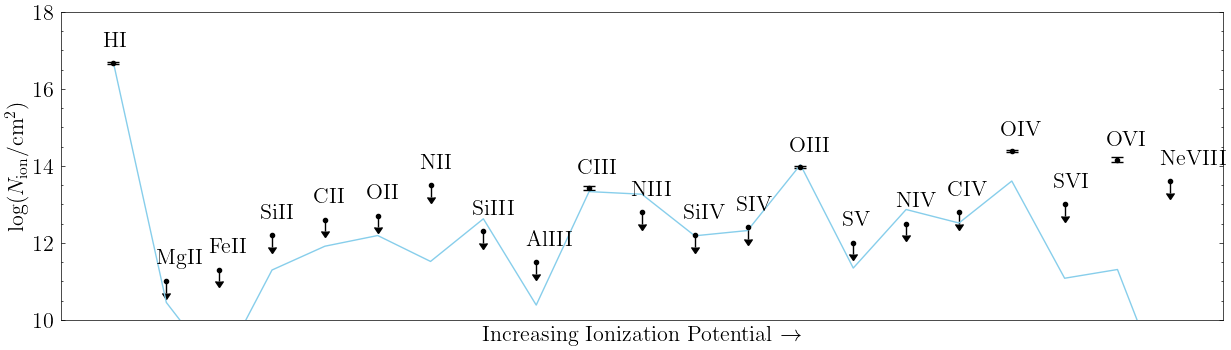

In [17]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='skyblue')

# Single phase solution

Get column density ratios

In [30]:
gen_logN_ratio_str(logN_dict['CIV'], logN_dict['CIII'])

'<-0.62, 0.17'

In [31]:
logN_ratio_dict = {#'OIV/OIII': '0.45, -0.04, 0.04',
                   'OII/OIII':'<-1.3, 0.1',
                   'SIV/OIII': '<-1.6, 0.1',
                   'SV/OIII': '<-2.0, 0.1',
                   'CII/CIII': '<-0.8, 0.2',
                   'CIV/CIII': '<-0.6, 0.2'}

Generate predicted column density ratios

(-5.0, 1.0)

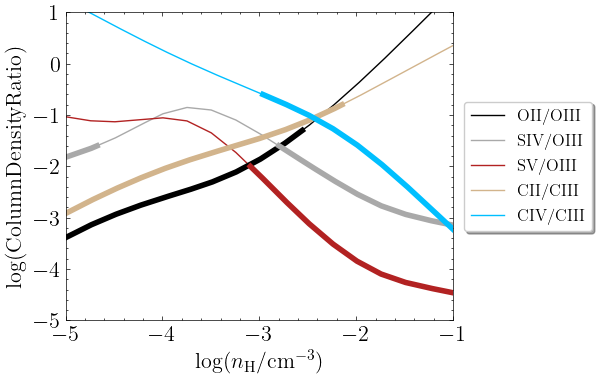

In [32]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict, 
                logN_HI_ref=12.5, log_metals_ref=-2.5)

ax.set_xlim(-5, -1)
ax.set_ylim(-5, 1)

In [33]:
def log_probability(params, logN_ratio_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    log_hdens = params[0]
    
    lp = log_prior_hdens(log_hdens)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_hdens(log_hdens, logN_ratio_dict, species_logN_interp)

In [34]:
logN_ratio_dict

{'OII/OIII': '<-1.3, 0.1',
 'SIV/OIII': '<-1.6, 0.1',
 'SV/OIII': '<-2.0, 0.1',
 'CII/CIII': '<-0.8, 0.2',
 'CIV/CIII': '<-0.6, 0.2'}

In [35]:
pos = np.array(-2.8) + 1e-4 * np.random.randn(200, 1)
nwalkers, ndim = pos.shape

In [36]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_ratio_dict, species_logN_interp)
)

In [37]:
#sampler.run_mcmc(pos, 500, progress=True);

In [38]:
#flat_samples_hdens = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens'])

#flat_samples_hdens.to_csv(savedir+'hdens_op.csv', index=False)

flat_samples_hdens = pd.read_csv(savedir+'hdens_op.csv')

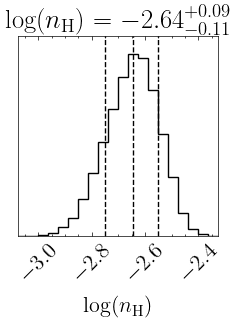

In [39]:
fig = corner.corner(
    flat_samples_hdens, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [40]:
grid_points_hdens = np.array([[12, log_hdens, -3] for log_hdens in flat_samples_hdens['log_hdens']])

In [41]:
logN_offset = 13.97-np.mean(species_logN_interp['O+2'](grid_points_hdens))

Calculate the C/O ratio

In [42]:
logN_CIII_obs = np.random.normal(loc=13.42, scale=0.09, size=len(flat_samples_hdens))

In [43]:
C_O_dist_CIII = logN_CIII_obs-(logN_offset+species_logN_interp['C+2'](grid_points_hdens))
C_O_dist = C_O_dist_CIII

In [44]:
get_quantiles(C_O_dist)

-0.39 -0.14 0.13


Plot models

In [45]:
logN_dict = {#'HI':'16.67, -0.02, +0.02',
            'CII':'<12.6',
            'CIII':'13.42, -0.06, +0.09',
            'CIV':'<12.8',
            #'NII':'<13.5',
            #'NIII':'<12.8',
            #'NIV':'<12.5',
            'OII':'<12.7',
            'OIII':'13.97, -0.03, +0.03',
            'OIV':'14.38, -0.02, +0.02',
            'OVI':'14.16, -0.07, +0.07',
            'NeVIII':'<13.6',
            'MgII':'<11.0',
            #'AlIII':'<11.5',
            #'SiII':'<12.2',
            #'SiIII':'<12.3',
            #'SiIV':'<12.2',
            'SIV':'<12.4',
            'SV':'<12.0',
            'SVI':'<13.0',}
            #'FeII':'<11.3',}

In [46]:
sample_indices_hdens = np.random.randint(low=0, high=len(flat_samples_hdens), size=200)

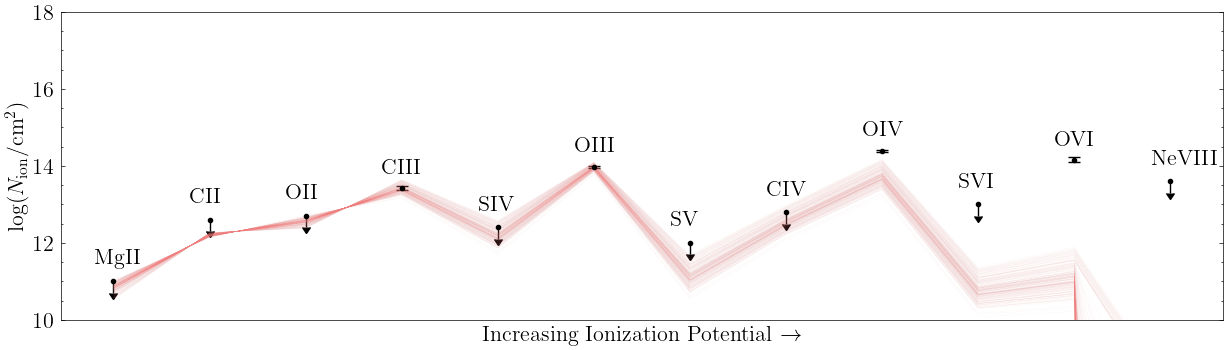

In [47]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_hdens)):
    
    idx = sample_indices_hdens[i]
    flat_samples_row = flat_samples_hdens.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    
    logN_species_test = predict_col_dens(logN_dict, 12, log_hdens, 
                                         -3, species_logN_interp, {'C': np.median(C_O_dist)})

    # Plot
    ax.plot(np.arange(len(logN_species_test)), 
            np.array(logN_species_test)+logN_offset,
            color='lightcoral', lw=.2, alpha=.1)

Plot cloud sizes

In [48]:
#l_dist = np.array([get_cloud_size(16.67, log_hdens, species_logN_interp) for log_hdens in flat_samples_hdens['log_hdens']])

In [49]:
#plt.hist(l_dist, bins=45)

In [50]:
get_cloud_size(16.67, -2.6, species_logN_interp)

7.050668427393466

# Two-phase solution: low density phase

In [51]:
def log_probability(params, logN_ratio_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    log_hdens = params[0]
    
    lp = log_prior_hdens(log_hdens)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_hdens(log_hdens, logN_ratio_dict, species_logN_interp)

In [52]:
logN_dict = {#'HI':'16.67, -0.02, +0.02',
            #'CII':'<12.6',
            #'CIII':'13.42, -0.06, +0.09',
            #'CIV':'<12.8',
            #'NII':'<13.5',
            #'NIII':'<12.8',
            #'NIV':'<12.5',
            #'OII':'<12.7',
            'OIII':'<13.97',
            'OIV':'14.38, -0.02, +0.02',
            'OVI':'<14.16',#'14.16, -0.07, +0.07',
            'NeVIII':'<13.6',
            #'MgII':'<11.0',
            #'AlIII':'<11.5',
            #'SiII':'<12.2',
            #'SiIII':'<12.3',
            #'SiIV':'<12.2',
            'SIV':'<12.4',
            'SV':'<12.0',
            'SVI':'<13.0',}
            #'FeII':'<11.3',}

Get column density ratios

In [53]:
gen_logN_ratio_str(logN_dict['SV'], logN_dict['OIV'])

'<-2.38, 0.14'

In [54]:
logN_ratio_dict = {#'SVI/OIV': '<-1.4, 0.1',
                   'OVI/OIV': '<-0.2, 0.1',
                   'OIII/OIV': '<-0.4, 0.1',
                   'NeVIII/OIV': '<-0.8, 0.1',
                   #'SV/OIV': '<-2.4, 0.1'
                  }

(-5.0, 5.0)

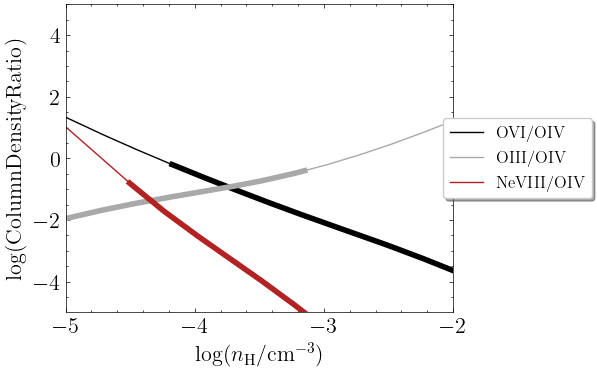

In [55]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)

ax.set_xlim(-5, -2)
ax.set_ylim(-5, 5)

In [56]:
pos = np.array(-3.8) + 1e-6 * np.random.randn(200, 1)
#nwalkers, ndim = pos.shape

In [57]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_ratio_dict, species_logN_interp)
)

In [58]:
#sampler.run_mcmc(pos, 500, progress=True);

In [59]:
#flat_samples_hdens = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens'])

#flat_samples_hdens.to_csv(savedir+'hdens_lo.csv', index=False)

flat_samples_hdens = pd.read_csv(savedir+'hdens_lo.csv')

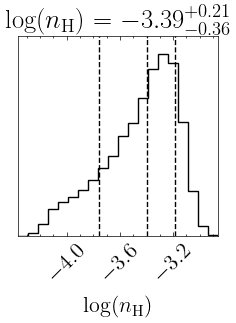

In [60]:
fig = corner.corner(
    flat_samples_hdens, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [61]:
grid_points_hdens = np.array([[12, log_hdens, -3] for log_hdens in flat_samples_hdens['log_hdens']])

In [62]:
hist, bins = np.histogram(species_logN_interp['O+3'](grid_points_hdens), bins=1000)
centers = .5*(bins[1:]+bins[:-1])

Text(0.5, 0, '$\\log N_{\\mathrm{OIV, ref}}$')

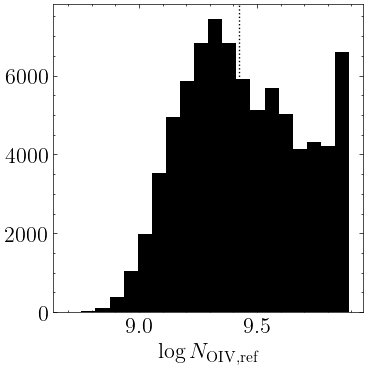

In [63]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['O+3'](grid_points_hdens), bins=20)
ax.axvline(np.median(species_logN_interp['O+3'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{OIV, ref}}$')

#ax.set_xlim(9.8, 9.9)

Text(0.5, 0, '$\\log N_{\\mathrm{OIII, ref}}$')

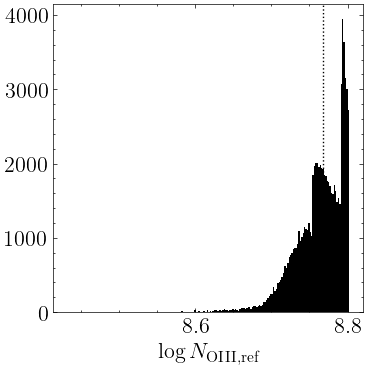

In [64]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['O+2'](grid_points_hdens), bins=200)
ax.axvline(np.median(species_logN_interp['O+2'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{OIII, ref}}$')

#ax.set_xlim(9.8, 9.9)

Text(0.5, 0, '$\\log N_{\\mathrm{CIII, ref}}$')

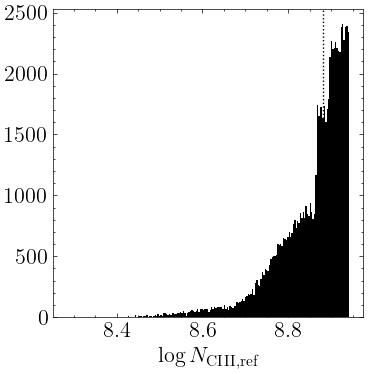

In [65]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['C+2'](grid_points_hdens), bins=200)
ax.axvline(np.median(species_logN_interp['C+2'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{CIII, ref}}$')

#ax.set_xlim(9.8, 9.9)

Get the offset

In [66]:
logN_offset = 14.38-np.median(species_logN_interp['O+3'](grid_points_hdens))

In [67]:
logN_offset

4.9581979032579895

Get yields

In [68]:
get_quantiles(logN_offset+species_logN_interp['O+2'](grid_points_hdens))

13.73 -0.04 0.03


In [69]:
get_quantiles(logN_offset+species_logN_interp['C+2'](grid_points_hdens))

13.84 -0.1 0.04


In [70]:
#12.6-13.6

Plot models

In [71]:
logN_dict = {#'HI':'16.67, -0.02, +0.02',
            #'CII':'<12.6',
            'CIII':'13.42, -0.06, +0.09',
            'CIV':'<12.8',
            #'NII':'<13.5',
            #'NIII':'<12.8',
            #'NIV':'<12.5',
            #'OII':'<12.7',
            'OIII':'13.97, -0.03, +0.03',
            'OIV':'14.38, -0.02, +0.02',
            'OVI':'<14.16',#'14.16, -0.07, +0.07',
            'NeVIII':'<13.6',
            #'MgII':'<11.0',
            #'AlIII':'<11.5',
            #'SiII':'<12.2',
            #'SiIII':'<12.3',
            #'SiIV':'<12.2',
            'SIV':'<12.4',
            'SV':'<12.0',
            'SVI':'<13.0',}
            #'FeII':'<11.3',}

In [72]:
sample_indices_hdens = np.random.randint(low=0, high=len(flat_samples_hdens), size=200)

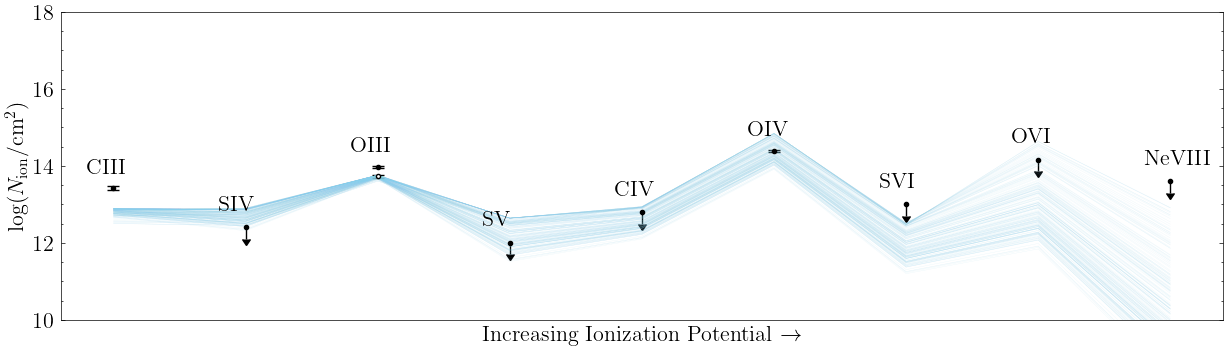

In [73]:
fig, ax = plot_column_densities_obs(logN_dict)

ax.errorbar(x=2, y=13.73, yerr=0.04, color='black', linestyle='None', mfc='white',
        fmt='o', markersize=3, capsize=4)

#ax.errorbar(x=1, y=13.98, yerr=0.08, color='black', linestyle='None', mfc='white',
#        fmt='o', markersize=3, capsize=4)

for i in range(len(sample_indices_hdens)):
    
    idx = sample_indices_hdens[i]
    flat_samples_row = flat_samples_hdens.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    
    logN_species_test = predict_col_dens(logN_dict, 12, log_hdens, 
                                         -3, species_logN_interp, {'C': -1})

    # Plot
    ax.plot(np.arange(len(logN_species_test)), 
            np.array(logN_species_test)+logN_offset,
            color='skyblue', lw=.2, alpha=.2)

Calculate residual for OIII

In [74]:
logN_OIII_tot = np.random.normal(loc=13.97, scale=0.03, size=1000)
logN_OIII_lo_dens = np.random.normal(loc=13.73, scale=0.04, size=1000)
logN_OIII_hi_dens = np.log10(10**logN_OIII_tot - 10**logN_OIII_lo_dens)

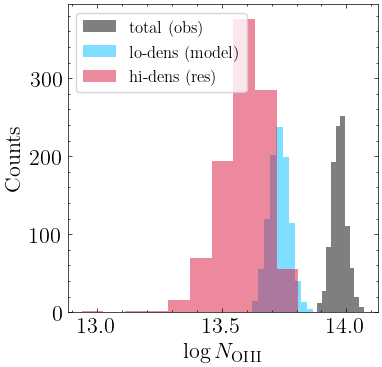

In [75]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(logN_OIII_tot, label='total (obs)', alpha=0.5)
ax.hist(logN_OIII_lo_dens, label='lo-dens (model)', alpha=0.5)
ax.hist(logN_OIII_hi_dens, label='hi-dens (res)', alpha=0.5)

ax.set_xlabel(r'$\log N_{\mathrm{OIII}}$')
ax.set_ylabel('Counts')

#ax.set_xlim(13.81,14.39)
ax.legend(loc='upper left')

In [76]:
logN_OIII_hi_dens_clean = logN_OIII_hi_dens[~np.isnan(logN_OIII_hi_dens)]

In [77]:
get_quantiles(logN_OIII_hi_dens_clean)

13.6 -0.1 0.08


# Two-phase solution: high density phase

In [78]:
logN_dict = {#'HI':'16.67, -0.02, +0.02',
            #'CII':'<12.6',
            #'CIII':'13.42, -0.06, +0.09',
            #'CIV':'<12.8',
            #'NII':'<13.5',
            #'NIII':'<12.8',
            #'NIV':'<12.5',
            'OII':'<12.7',
            'OIII':'13.60, -0.09, +0.09',
            'OIV':'<14.38',
            #'OVI':'14.16, -0.07, +0.07',
            #'NeVIII':'<13.6',
            'MgII':'<11.0',
            #'AlIII':'<11.5',
            #'SiII':'<12.2',
            #'SiIII':'<12.3',
            #'SiIV':'<12.2',
            'SIV':'<12.4',
            'SV':'<12.0',}
            #'SVI':'<13.0',
            #'FeII':'<11.3',}

Get column density ratios

In [79]:
gen_logN_ratio_str(logN_dict['OIV'], logN_dict['OIII'])

'<0.78, 0.17'

In [80]:
logN_ratio_dict = {#'CIV/CIII': '<-0.8, 0.2',
                   #'CII/CIII': '<-0.8, 0.2',
                    'SV/OIII': '<-1.6, 0.2',
                   'SIV/OIII': '<-1.2, 0.2',
                   'OII/OIII': '<-0.9, 0.2',
                   'MgII/OIII': '<-2.6, 0.2',
                   'OIV/OIII': '<0.8, 0.2'
                  }

(-5.0, 5.0)

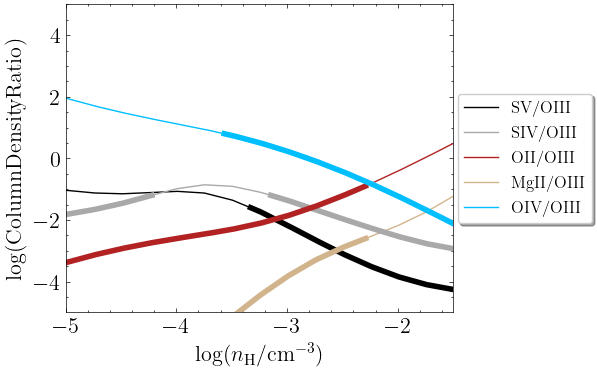

In [81]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)

ax.set_xlim(-5, -1.5)
ax.set_ylim(-5, 5)

In [82]:
pos = np.array(-2.6) + 1e-6 * np.random.randn(200, 1)
nwalkers, ndim = pos.shape

In [83]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_ratio_dict, species_logN_interp)
)

In [84]:
#sampler.run_mcmc(pos, 500, progress=True);

In [85]:
#flat_samples_hdens = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens'])

#flat_samples_hdens.to_csv(savedir+'hdens_hi.csv', index=False)

flat_samples_hdens = pd.read_csv(savedir+'hdens_hi.csv')

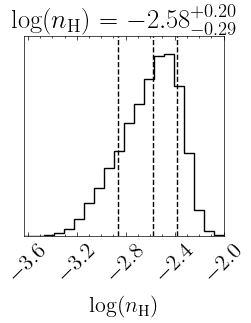

In [86]:
fig = corner.corner(
    flat_samples_hdens, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [87]:
grid_points_hdens = np.array([[12, log_hdens, -3] for log_hdens in flat_samples_hdens['log_hdens']])

In [88]:
logN_offset = 13.60-np.median(species_logN_interp['O+2'](grid_points_hdens))

In [89]:
logN_offset

5.123561705333474

Calculate the C/O ratio

In [90]:
logN_CIII_obs = np.random.normal(loc=13.42, scale=0.09, size=len(flat_samples_hdens))

In [91]:
C_O_dist_CIII = logN_CIII_obs-(logN_offset+species_logN_interp['C+2'](grid_points_hdens))
C_O_dist = C_O_dist_CIII

In [92]:
get_quantiles(C_O_dist)

0.0 -0.29 0.24


Plot models

In [93]:
logN_dict = {#'HI':'16.67, -0.02, +0.02',
            'CII':'<12.6',
            'CIII':'13.42, -0.06, +0.09',
            'CIV':'<12.8',
            #'NII':'<13.5',
            #'NIII':'<12.8',
            #'NIV':'<12.5',
            'OII':'<12.7',
            'OIII':'13.60, -0.09, +0.09',
            'OIV':'<14.38',
            #'OVI':'14.16, -0.07, +0.07',
            #'NeVIII':'<13.6',
            'MgII':'<11.0',
            #'AlIII':'<11.5',
            #'SiII':'<12.2',
            #'SiIII':'<12.3',
            #'SiIV':'<12.2',
            'SIV':'<12.4',
            'SV':'<12.0',}
            #'SVI':'<13.0',
            #'FeII':'<11.3',}

In [94]:
sample_indices_hdens = np.random.randint(low=0, high=len(flat_samples_hdens), size=200)

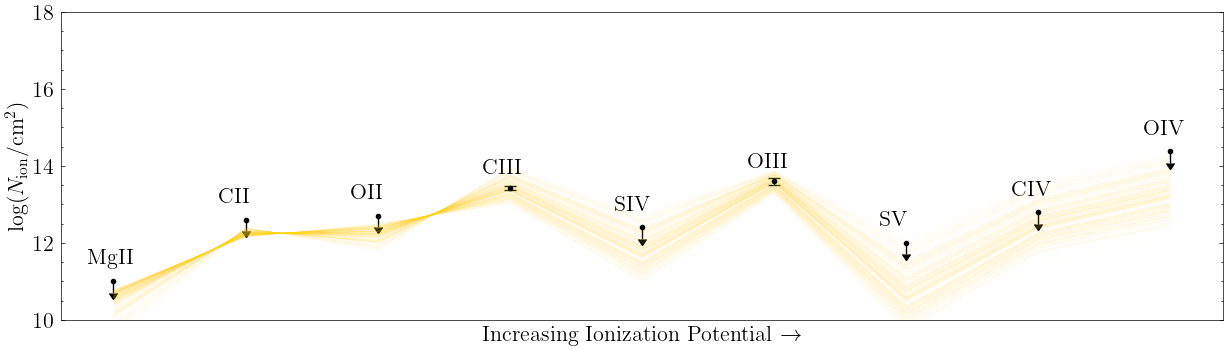

In [95]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_hdens)):
    
    idx = sample_indices_hdens[i]
    flat_samples_row = flat_samples_hdens.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    
    logN_species_test = predict_col_dens(logN_dict, 12, log_hdens, 
                                         -3, species_logN_interp, {'C': np.median(C_O_dist)})

    # Plot
    ax.plot(np.arange(len(logN_species_test)), 
            np.array(logN_species_test)+logN_offset,
            color='gold', lw=.2, alpha=.1)

In [96]:
get_cloud_size(16.67, -2.6, species_logN_interp)

7.050668427393466

# A higher density phase

In [100]:
def lambda_log_prior(params):

    # Grid parameters being varied
    log_hdens, log_metals = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    if -2.7<log_hdens<log_hdens_max and log_metals_min<log_metals<log_metals_max:
        return 0.0
    return -np.inf

In [101]:
def lambda_log_likelihood(params, logN_dict, species_logN_interp):

    # Only parameters being varied
    log_hdens, log_metals = params
    
    # Construct the full range of parameters
    # Empty dictionary means solar abundance patterns
    params_full = np.array([logN_HI_test, log_hdens, log_metals, {}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood(params_full, logN_dict, species_logN_interp)    

In [102]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood(params, logN_dict, species_logN_interp)

Fit things

In [103]:
logN_dict = {#'HI':'16.67, -0.02, +0.02',
            #'CII':'<12.6',
            #'CIII':'13.42, -0.06, +0.09',
            #'CIV':'<12.8',
            #'NII':'<13.5',
            #'NIII':'<12.8',
            #'NIV':'<12.5',
            'OII':'<12.7',
            'OIII':'<13.60',
            #'OIV':'<14.38',
            #'OVI':'14.16, -0.07, +0.07',
            #'NeVIII':'<13.6',
            'MgII':'<11.0',
            #'AlIII':'<11.5',
            'SiII':'<12.2',}
            #'SiIII':'<12.3',
            #'SiIV':'<12.2',
            #'SIV':'<12.4',
            #'SV':'<12.0',}
            #'SVI':'<13.0',
            #'FeII':'<11.3',}

In [104]:
logN_HI_test = 16.67
log_hdens_test = -1
log_metals_test = -2.5

In [105]:
logN_species_test = predict_col_dens(logN_dict, logN_HI_test, log_hdens_test, log_metals_test, species_logN_interp)

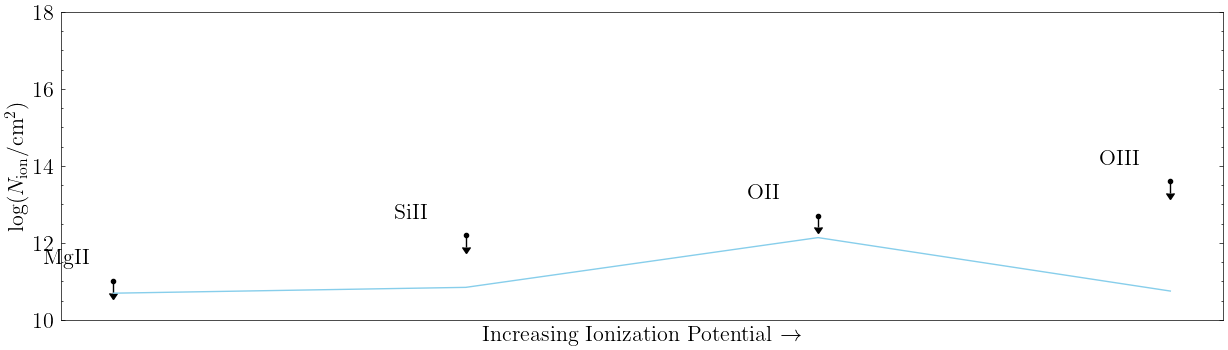

In [106]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='skyblue')

In [107]:
pos = np.array([log_hdens_test, log_metals_test]) + 1e-4 * np.random.randn(200, 2)
nwalkers, ndim = pos.shape

In [108]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [109]:
#sampler.run_mcmc(pos, 500, progress=True);

In [110]:
#flat_samples_hier_dens = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens', 'log_metals'])
#flat_samples_hier_dens.to_csv(savedir+'hdens_hier.csv', index=False)

flat_samples_hier_dens = pd.read_csv(savedir+'hdens_hier.csv')

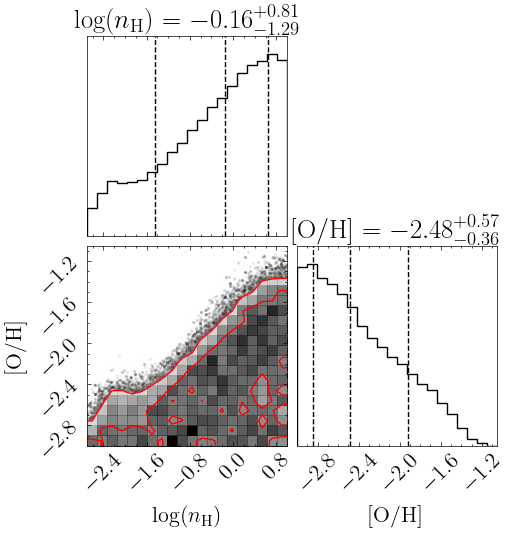

In [111]:
fig = corner.corner(
    flat_samples_hier_dens, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$', r'$[\mathrm{O/H}]$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

Now plot the best models

In [112]:
logN_dict = {#'HI':'16.67, -0.02, +0.02',
            #'CII':'<12.6',
            #'CIII':'13.42, -0.06, +0.09',
            #'CIV':'<12.8',
            #'NII':'<13.5',
            #'NIII':'<12.8',
            #'NIV':'<12.5',
            'OII':'<12.7',
            'OIII':'13.97, -0.03, +0.03',
            'OIV':'14.38, -0.02, +0.02',
            #'OVI':'14.16, -0.07, +0.07',
            #'NeVIII':'<13.6',
            'MgII':'<11.0',}
            #'AlIII':'<11.5',
            #'SiII':'<12.2',
            #'SiIII':'<12.3',
            #'SiIV':'<12.2',
            #'SIV':'<12.4',
            #'SV':'<12.0',}
            #'SVI':'<13.0',
            #'FeII':'<11.3',}

In [113]:
sample_indices_hier = np.random.randint(low=0, high=len(flat_samples_hier_dens), size=500)

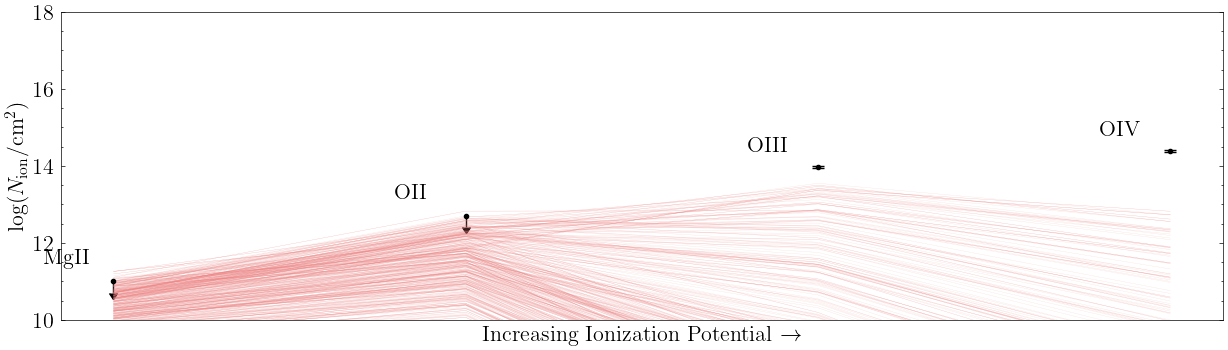

In [114]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_hier)):
    
    idx = sample_indices_hier[i]
    flat_samples_row = flat_samples_hier_dens.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    log_metals = flat_samples_row['log_metals']
    
    logN_species_test = (predict_col_dens(logN_dict, 
                                          logN_HI_test, 
                                          log_hdens, 
                                          log_metals, 
                                          species_logN_interp))
    
    #logN_species_test[0] = 15.44

    # Plot
    ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral', lw=.2, alpha=.3)

Get cloud sizes

In [115]:
#log_hdens_arr = np.array(flat_samples_hier_dens['log_hdens'])

In [116]:
#l_dist = [get_cloud_size(logN_HI_test, log_hdens, species_logN_interp) for log_hdens in log_hdens_arr]

In [117]:
#fig, ax = plt.subplots(1, figsize=(5,5))

#ax.hist(l_dist, bins=10)

#ax.set_xlabel(r'$l (\mathrm{kpc})$')
#ax.set_ylabel('Counts')

In [118]:
#np.percentile(l_dist, 100*cdf_3sig)

# Three phase solution

In [120]:
def lambda_log_prior_three_phase(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, logN_HI_p3, log_hdens_p3, log_metals_p3 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}, 
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {}, 
                            logN_HI_p3, log_hdens_p3, log_metals_p3, {}])
    
    return log_prior_three_phase(params_full, species_logN_interp)

In [121]:
def lambda_log_likelihood_three_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, logN_HI_p3, log_hdens_p3, log_metals_p3 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {},
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {},
                            logN_HI_p3, log_hdens_p3, log_metals_p3, {}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_three_phase(params_full, logN_dict, species_logN_interp)    

In [122]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_three_phase(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_three_phase(params, logN_dict, species_logN_interp)

Fit things

In [123]:
logN_dict = {#'HI':'16.67, -0.02, +0.02',
            #'CII':'<12.6',
            #'CIII':'13.42, -0.06, +0.09',
            #'CIV':'<12.8',
            #'NII':'<13.5',
            #'NIII':'<12.8',
            #'NIV':'<12.5',
            'OII':'<12.7',
            'OIII':'13.97, -0.03, +0.03',
            'OIV':'14.38, -0.02, +0.02',
            'OVI':'<14.16',
            'NeVIII':'<13.6',
            'MgII':'<11.0',
            #'AlIII':'<11.5',
            #'SiII':'<12.2',
            #'SiIII':'<12.3',
            #'SiIV':'<12.2',
            #'SIV':'<12.4',
            #'SV':'<12.0',
            'SVI':'<13.0',}
            #'FeII':'<11.3',}

In [124]:
logN_HI_test_p1 = 16.67
log_hdens_test_p1 = 0
log_metals_test_p1 = -2.5

logN_HI_test_p2 = 15.5
log_hdens_test_p2 = -2.65
log_metals_test_p2 = -1.2

logN_HI_test_p3 = 14.7
log_hdens_test_p3 = -3.7
log_metals_test_p3 = -0.8

In [125]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test_p1, log_hdens_test_p1, log_metals_test_p1, species_logN_interp))
logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, species_logN_interp))
logN_species_test_p3 = np.array(predict_col_dens(logN_dict, logN_HI_test_p3, log_hdens_test_p3, log_metals_test_p3, species_logN_interp))
logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2 + 10**logN_species_test_p3)

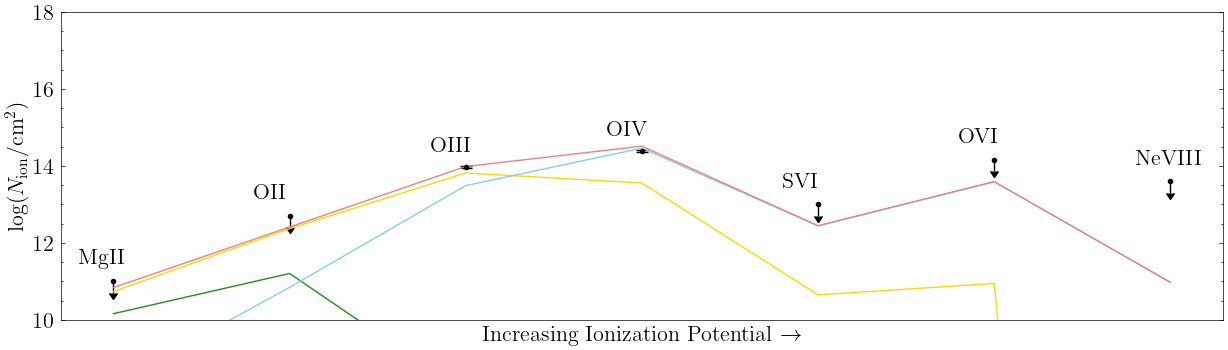

In [126]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='forestgreen')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold')
ax.plot(np.arange(len(logN_species_test_p3)), logN_species_test_p3, color='skyblue')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [127]:
pos = np.array([log_hdens_test_p1, log_metals_test_p2, 
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2,
                logN_HI_test_p3, log_hdens_test_p3, log_metals_test_p3]) + 1e-4 * np.random.randn(200, 8)
nwalkers, ndim = pos.shape

In [128]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [129]:
#species_logN_interp['S+5']([16.67, 0.1, -0.6]), species_logN_interp['S+5']([14.9, -2.7, -1.0]), species_logN_interp['S+5']([14.9, -3.7, -1.0])

In [136]:
#sampler.run_mcmc(pos, 500, progress=True);

In [137]:
#flat_samples_three_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens_p1', 'log_metals_p1', 
#                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2',
#                                         'logN_HI_p3', 'log_hdens_p3', 'log_metals_p3'])
#flat_samples_three_phase.to_csv(savedir+'three_phase.csv', index=False)

flat_samples_three_phase = pd.read_csv(savedir+'three_phase.csv')

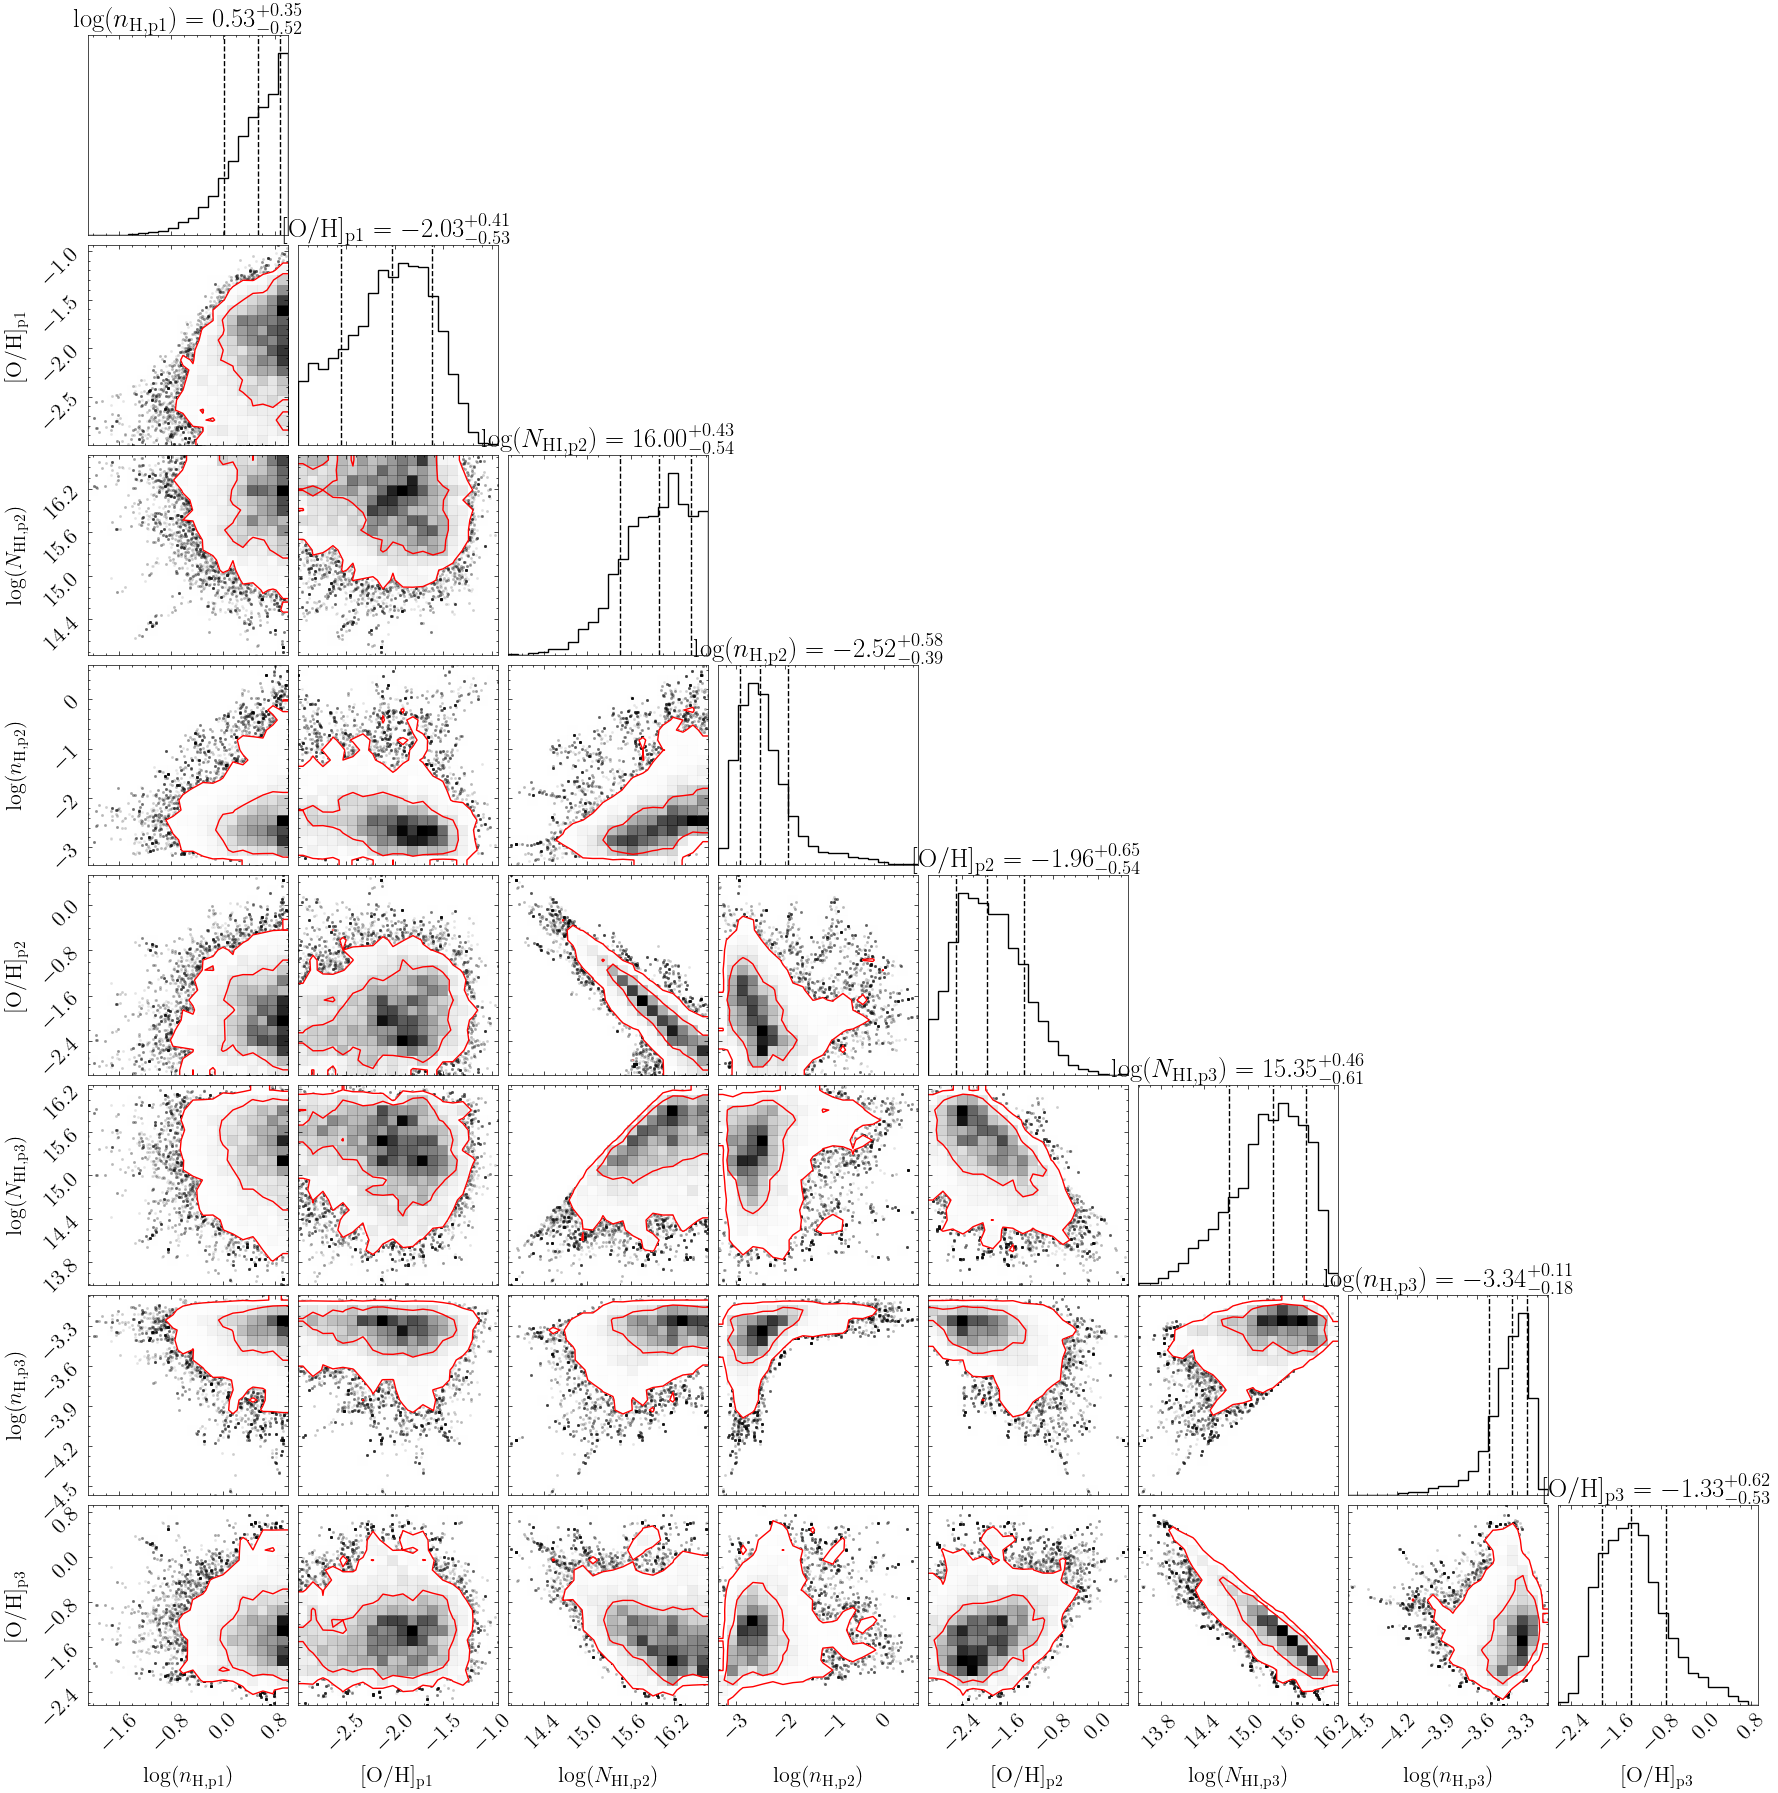

In [138]:
fig = corner.corner(
    flat_samples_three_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$',
            r'$\log(N_\mathrm{HI, p3})$', r'$\log(n_\mathrm{H, p3})$', r'$[\mathrm{O/H}]_{\mathrm{p3}}$',], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

Now plot the best models

In [139]:
logN_dict = {#'HI':'16.67, -0.02, +0.02',
            'CII':'<12.6',
            'CIII':'13.42, -0.06, +0.09',
            'CIV':'<12.8',
            'NII':'<13.5',
            'NIII':'<12.8',
            'NIV':'<12.5',
            'OII':'<12.7',
            'OIII':'13.97, -0.03, +0.03',
            'OIV':'14.38, -0.02, +0.02',
            'OVI':'14.16, -0.07, +0.07',
            'NeVIII':'<13.6',
            'MgII':'<11.0',
            #'AlIII':'<11.5',
            'SiII':'<12.2',
            #'SiIII':'<12.3',
            #'SiIV':'<12.2',
            'SIV':'<12.4',
            'SV':'<12.0',
            'SVI':'<13.0',}
            #'FeII':'<11.3',}

In [140]:
sample_indices_three_phase = np.random.randint(low=0, high=len(flat_samples_three_phase), size=500)

(10.0, 16.0)

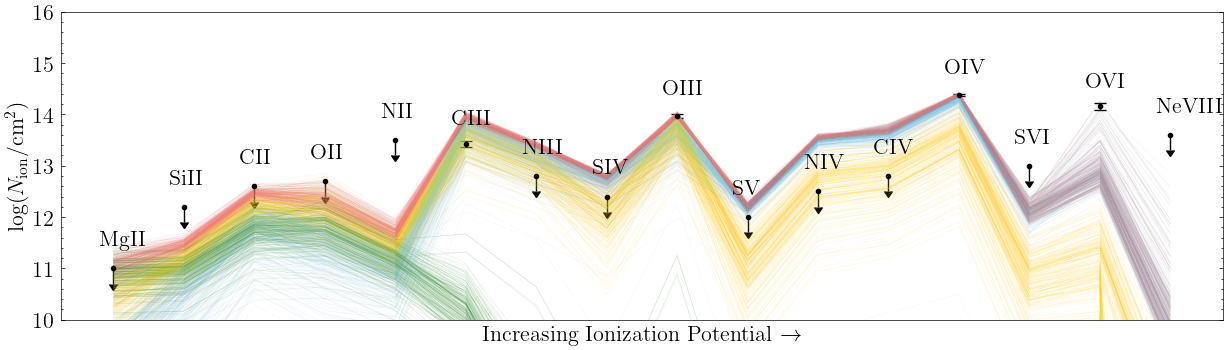

In [141]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_three_phase)):
    
    idx = sample_indices_hier[i]
    flat_samples_row = flat_samples_three_phase.iloc[i]
    
    log_hdens_p1 = flat_samples_row['log_hdens_p1']
    log_metals_p1 = flat_samples_row['log_metals_p1']
    
    logN_HI_p2 = flat_samples_row['logN_HI_p2']
    log_hdens_p2 = flat_samples_row['log_hdens_p2']
    log_metals_p2 = flat_samples_row['log_metals_p2']
    
    logN_HI_p3 = flat_samples_row['logN_HI_p3']
    log_hdens_p3 = flat_samples_row['log_hdens_p3']
    log_metals_p3 = flat_samples_row['log_metals_p3']
    
    logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test,  log_hdens_p1, log_metals_p1, species_logN_interp))
    logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_p2,  log_hdens_p2, log_metals_p2, species_logN_interp))
    logN_species_test_p3 = np.array(predict_col_dens(logN_dict, logN_HI_p3,  log_hdens_p3, log_metals_p3, species_logN_interp))

    logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2 + 10**logN_species_test_p3)

    # Plot
    ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='forestgreen', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p3)), logN_species_test_p3, color='skyblue', lw=.2, alpha=.1)

ax.set_ylim(10,16)

# Three phase solution (revisited)

In [263]:
def lambda_log_prior_three_phase(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, logN_HI_p3, log_hdens_p3, log_metals_p3, C_O_p3 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}, 
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C':C_O_p2}, 
                            logN_HI_p3, log_hdens_p3, log_metals_p3, {'C':C_O_p3}])
    
    return log_prior_three_phase(params_full, species_logN_interp)

In [264]:
def lambda_log_likelihood_three_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, logN_HI_p3, log_hdens_p3, log_metals_p3, C_O_p3 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}, 
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C':C_O_p2}, 
                            logN_HI_p3, log_hdens_p3, log_metals_p3, {'C':C_O_p3}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_three_phase(params_full, logN_dict, species_logN_interp)    

In [265]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_three_phase(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_three_phase(params, logN_dict, species_logN_interp)

Fit things

In [266]:
logN_dict = {#'HI':'16.67, -0.02, +0.02',
            #'CII':'<12.6',
            'CIII':'13.42, -0.06, +0.09',
            'CIV':'<12.8',
            #'NII':'<13.5',
            #'NIII':'<12.8',
            #'NIV':'<12.5',
            'OII':'<12.7',
            'OIII':'13.97, -0.03, +0.03',
            'OIV':'14.38, -0.02, +0.02',
            'OVI':'<14.16',
            #'NeVIII':'<13.6',
            'MgII':'<11.0',
            #'AlIII':'<11.5',
            'SiII':'<12.2',
            #'SiIII':'<12.3',
            #'SiIV':'<12.2',
            #'SIV':'<12.4',
            #'SV':'<12.0',
            'SVI':'<13.0',}
            #'FeII':'<11.3',}

In [267]:
logN_HI_test_p1 = 16.67
log_hdens_test_p1 = 0
log_metals_test_p1 = -1.8

logN_HI_test_p2 = 15.5
log_hdens_test_p2 = -2.65
log_metals_test_p2 = -1.2
C_O_test_p2 = -0.3

logN_HI_test_p3 = 14.7
log_hdens_test_p3 = -3.7
log_metals_test_p3 = -0.8
C_O_test_p3 = -1.2

In [268]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test, log_hdens_test_p1, log_metals_test_p1, species_logN_interp,
                                                ))
logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, species_logN_interp,
                                                {'C':C_O_test_p2}))
logN_species_test_p3 = np.array(predict_col_dens(logN_dict, logN_HI_test_p3, log_hdens_test_p3, log_metals_test_p3, species_logN_interp,
                                                {'C':C_O_test_p3}))
logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2 + 10**logN_species_test_p3)

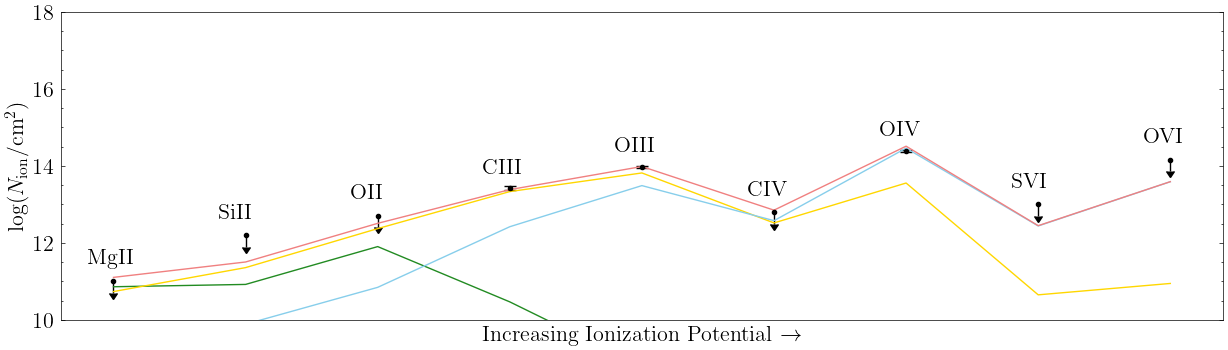

In [269]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='forestgreen')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold')
ax.plot(np.arange(len(logN_species_test_p3)), logN_species_test_p3, color='skyblue')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [270]:
pos = np.array([log_hdens_test_p1, log_metals_test_p2,
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, C_O_test_p2,
                logN_HI_test_p3, log_hdens_test_p3, log_metals_test_p3, C_O_test_p3]) + 1e-4 * np.random.randn(200, 10)
nwalkers, ndim = pos.shape

In [271]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [272]:
#species_logN_interp['S+5']([16.67, 0.1, -0.6]), species_logN_interp['S+5']([14.9, -2.7, -1.0]), species_logN_interp['S+5']([14.9, -3.7, -1.0])

In [273]:
sampler.run_mcmc(pos, 500, progress=True);

100%|█████████████████████████████████████████| 500/500 [06:57<00:00,  1.20it/s]


In [274]:
flat_samples_three_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
                                columns=['log_hdens_p1', 'log_metals_p1',
                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2', 'C_O_p2',
                                         'logN_HI_p3', 'log_hdens_p3', 'log_metals_p3', 'C_O_p3'])
flat_samples_three_phase.to_csv(savedir+'three_phase_C.csv', index=False)

#flat_samples_three_phase = pd.read_csv(savedir+'three_phase_C.csv')

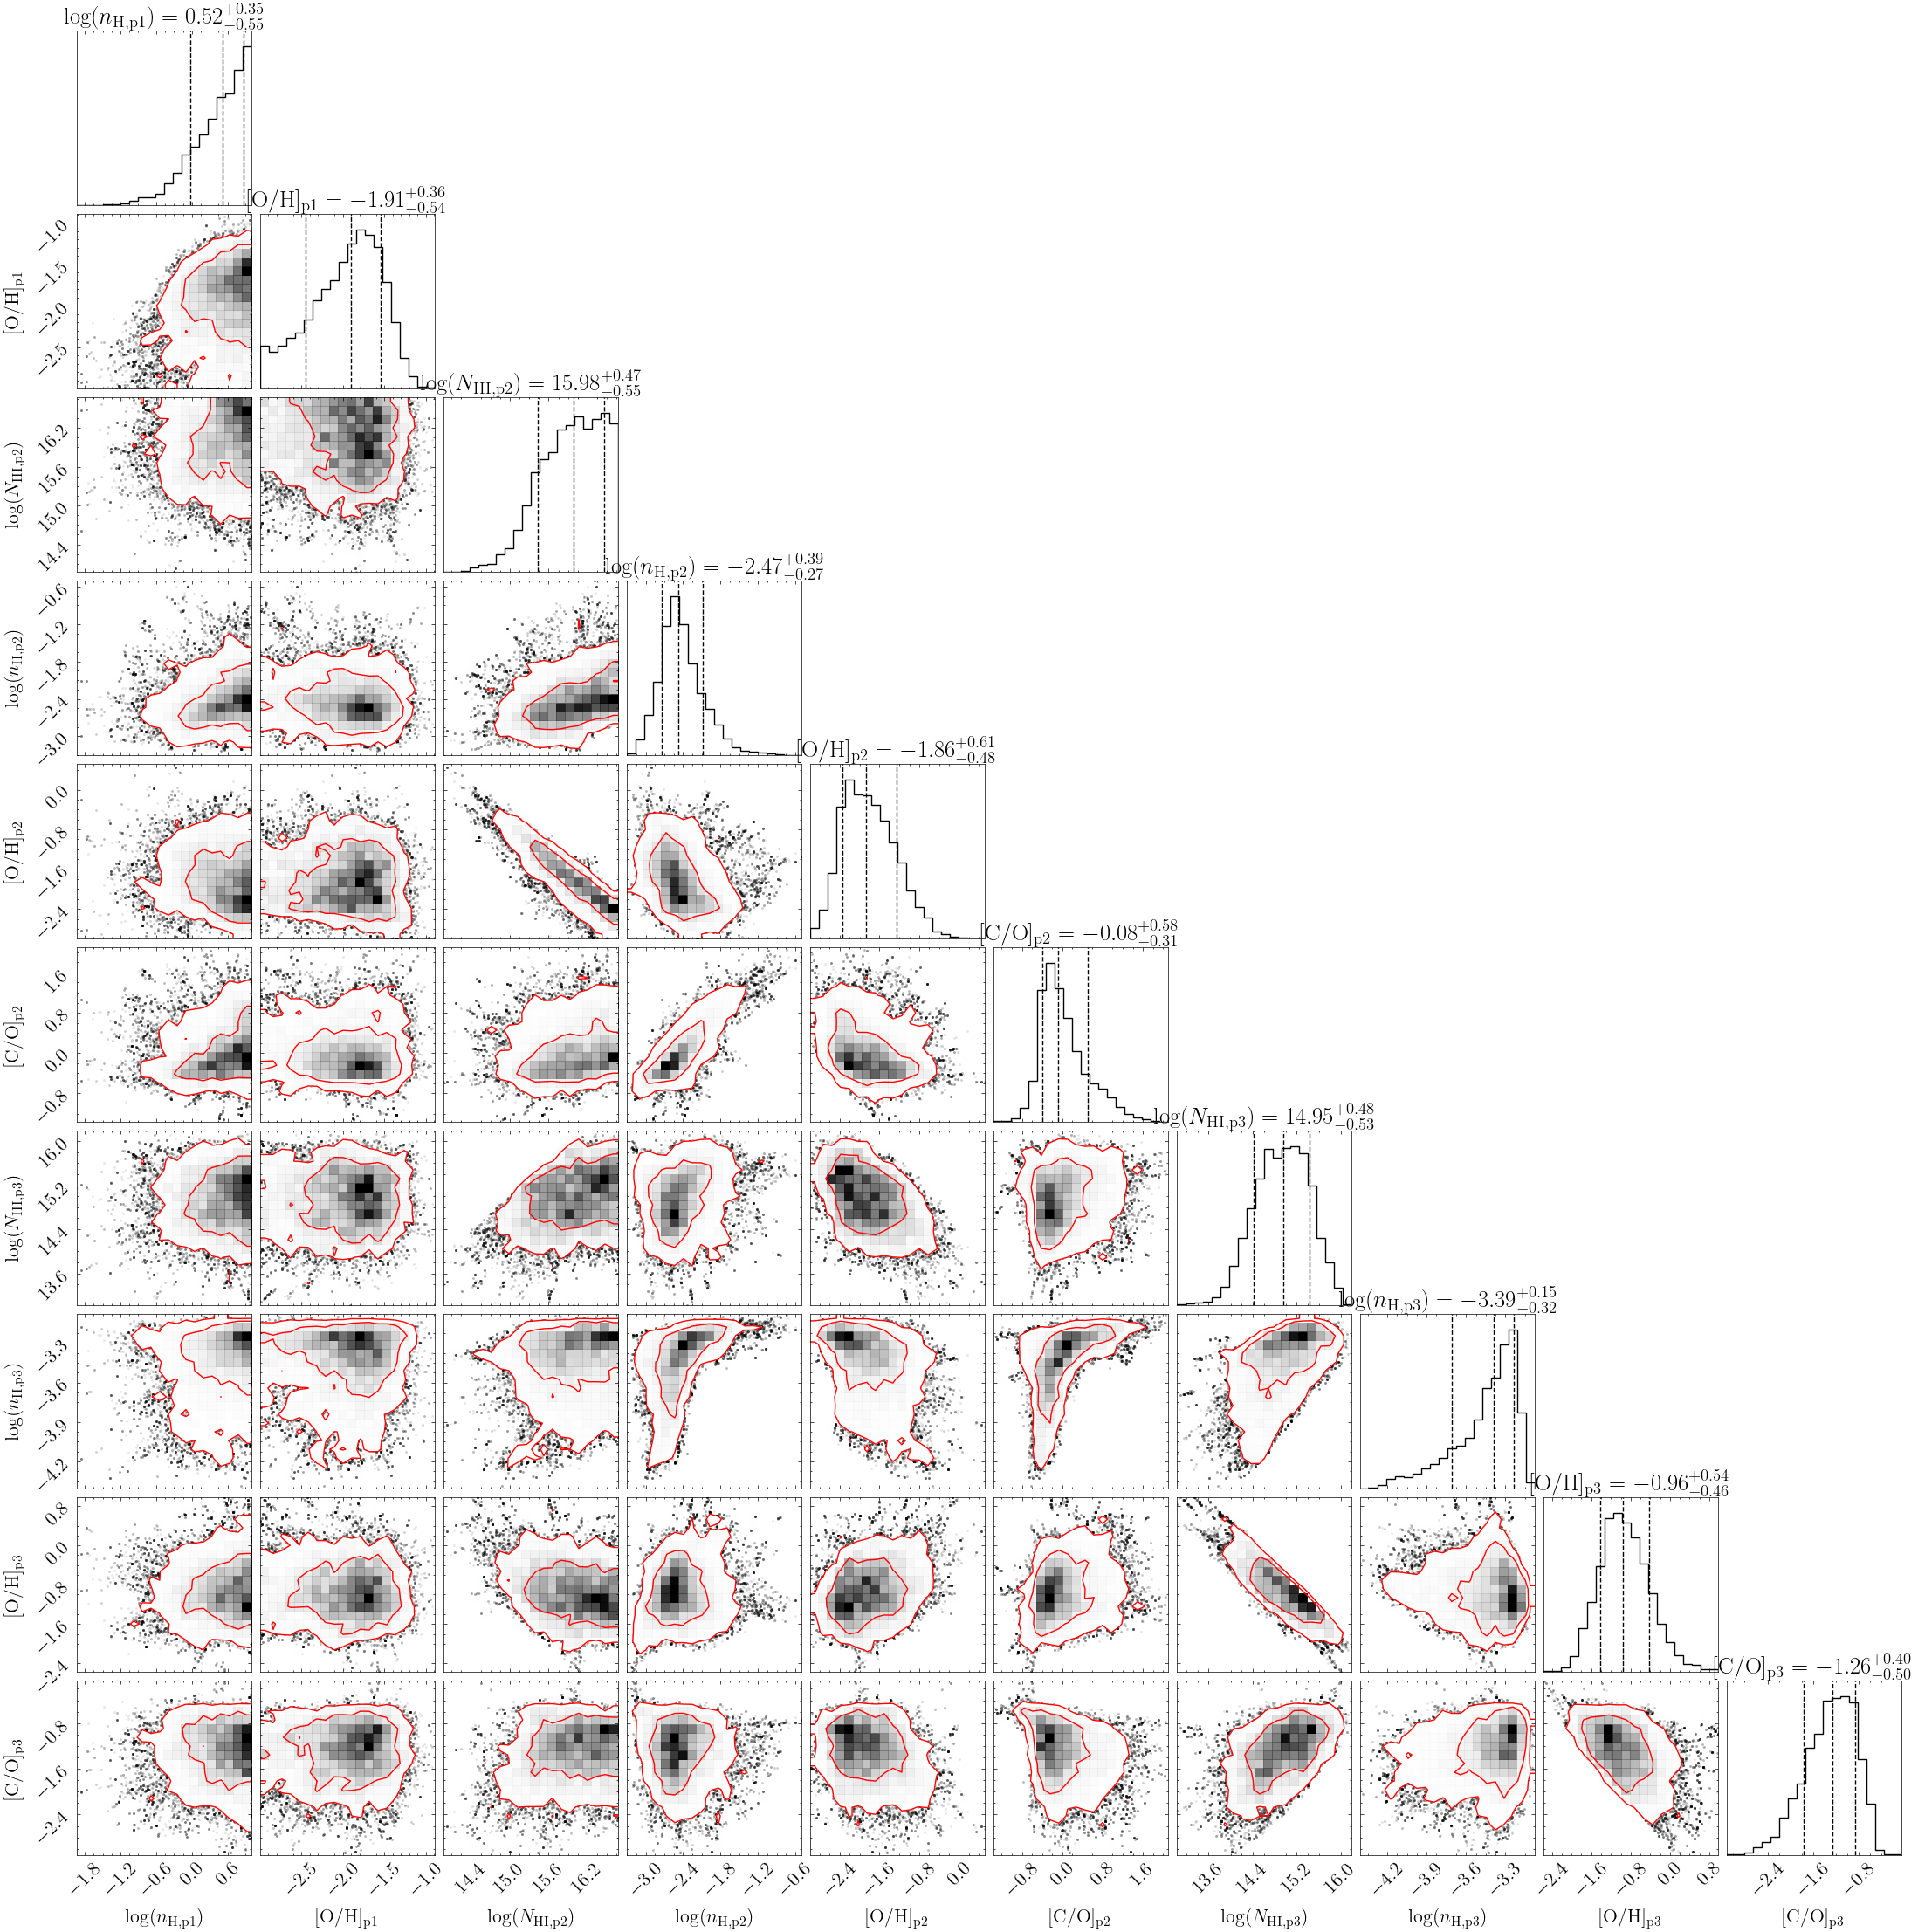

In [275]:
fig = corner.corner(
    flat_samples_three_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$',
            r'$[\mathrm{C/O}]_{\mathrm{p2}}$',
            r'$\log(N_\mathrm{HI, p3})$', r'$\log(n_\mathrm{H, p3})$', r'$[\mathrm{O/H}]_{\mathrm{p3}}$',
            r'$[\mathrm{C/O}]_{\mathrm{p3}}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [296]:
np.percentile(flat_samples_three_phase['log_hdens_p1'], 100*(1-cdf_3sig))

-1.3543215472560342

In [298]:
np.percentile(flat_samples_three_phase['log_metals_p1'], 100*cdf_3sig)

-1.0941343200649367

In [318]:
np.percentile(flat_samples_three_phase['C_O_p3'], 100*cdf_3sig)

-0.3500900702470835

In [276]:
#plt.hist(flat_samples_three_phase['log_metals_p1']+flat_samples_three_phase['C_O_p1'])

In [277]:
#plt.hist(flat_samples_two_phase['log_metals_p2']+flat_samples_two_phase['N_O_p2'])

Now plot the best models

In [281]:
logN_dict = {#'HI':'16.67, -0.02, +0.02',
            #'CII':'<12.6',
            'CIII':'13.42, -0.06, +0.09',
            'CIV':'<12.8',
            #'NII':'<13.5',
            #'NIII':'<12.8',
            #'NIV':'<12.5',
            'OII':'<12.7',
            'OIII':'13.97, -0.03, +0.03',
            'OIV':'14.38, -0.02, +0.02',
            'OVI':'14.16, -0.07, +0.07',
            #'NeVIII':'<13.6',
            #'MgII':'<11.0',
            #'AlIII':'<11.5',
            'SiII':'<12.2',
            #'SiIII':'<12.3',
            #'SiIV':'<12.2',
            #'SIV':'<12.4',
            #'SV':'<12.0',
            'SVI':'<13.0',}
            #'FeII':'<11.3',}

In [315]:
sample_indices_three_phase = np.random.randint(low=0, high=len(flat_samples_three_phase), size=100)

In [316]:
z_sys = 0.72882547

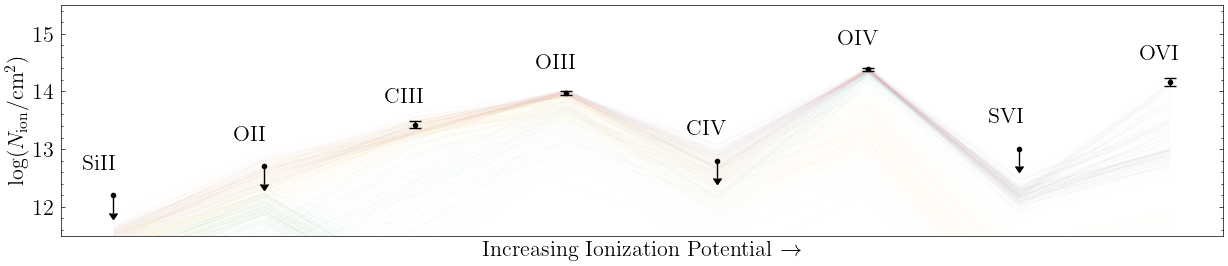

In [322]:
fig, ax = plt.subplots(1, figsize=(15,3))

for i in range(len(sample_indices_three_phase)):
    
    idx = sample_indices_three_phase[i]
    flat_samples_row = flat_samples_three_phase.iloc[i]
    
    log_hdens_p1 = flat_samples_row['log_hdens_p1']
    log_metals_p1 = flat_samples_row['log_metals_p1']
    
    logN_HI_p2 = flat_samples_row['logN_HI_p2']
    log_hdens_p2 = flat_samples_row['log_hdens_p2']
    log_metals_p2 = flat_samples_row['log_metals_p2']
    C_O_p2 = flat_samples_row['C_O_p2']
    
    logN_HI_p3 = flat_samples_row['logN_HI_p3']
    log_hdens_p3 = flat_samples_row['log_hdens_p3']
    log_metals_p3 = flat_samples_row['log_metals_p3']
    C_O_p3 = flat_samples_row['C_O_p3']
    
    logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test,  log_hdens_p1, log_metals_p1, species_logN_interp))
    logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_p2,  log_hdens_p2, log_metals_p2, species_logN_interp,
                                                    {'C':C_O_p2}))
    logN_species_test_p3 = np.array(predict_col_dens(logN_dict, logN_HI_p3,  log_hdens_p3, log_metals_p3, species_logN_interp,
                                                    {'C':C_O_p3}))

    logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2 + 10**logN_species_test_p3)

    # Plot
    ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral', lw=.1, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='forestgreen', lw=.1, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold', lw=.1, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p3)), logN_species_test_p3, color='skyblue', lw=.1, alpha=.1)

plot_column_densities_obs(logN_dict, fig, ax)

ax.set_ylim(11.5,15.5)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Get cloud sizes

In [299]:
l_p1 = np.zeros(len(flat_samples_three_phase))
l_p2 = np.zeros(len(flat_samples_three_phase))
l_p3 = np.zeros(len(flat_samples_three_phase))

In [300]:
for i in range(len(l_p1)):
    
    flat_samples_row = flat_samples_three_phase.iloc[i]
    
    l_p1[i] = get_cloud_size(logN_HI_test, flat_samples_row['log_hdens_p1'], species_logN_interp)
    l_p2[i] = get_cloud_size(flat_samples_row['logN_HI_p2'], flat_samples_row['log_hdens_p2'], species_logN_interp)
    l_p3[i] = get_cloud_size(flat_samples_row['logN_HI_p3'], flat_samples_row['log_hdens_p3'], species_logN_interp)

Text(0, 0.5, 'Counts')

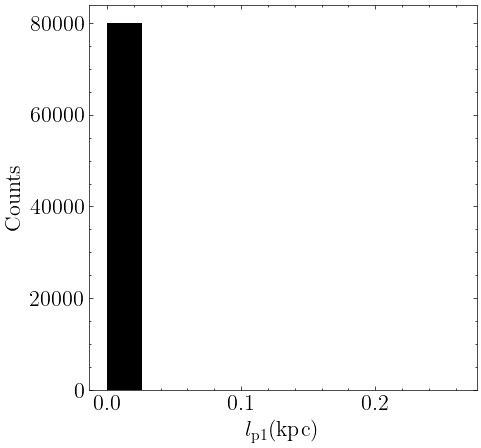

In [301]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(l_p1, bins=10)

ax.set_xlabel(r'$l_{\mathrm{p1}} (\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [302]:
np.percentile(l_p1, 100*cdf_3sig)

0.016276107062504232

Text(0, 0.5, 'Counts')

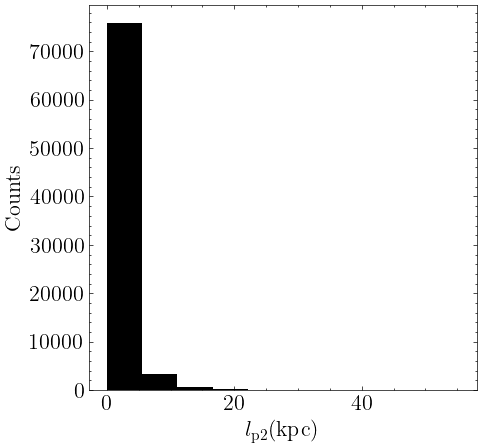

In [303]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(l_p2, bins=10)

ax.set_xlabel(r'$l_{\mathrm{p2}} (\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [304]:
np.percentile(l_p2, 100*cdf_3sig)

23.31598950836202

Text(0, 0.5, 'Counts')

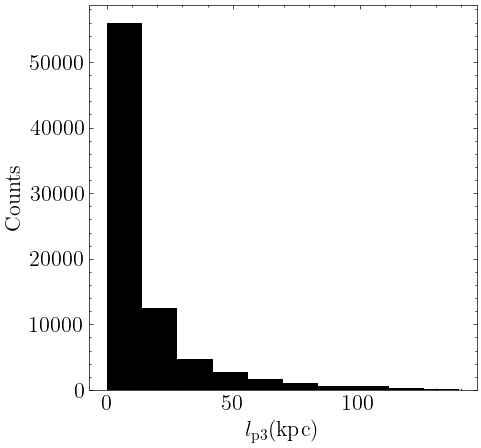

In [305]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(l_p3, bins=10)

ax.set_xlabel(r'$l_{\mathrm{p3}} (\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [306]:
np.percentile(l_p3, 100*cdf_3sig)

129.8695474770506